## Prepare the FID for solid Echo

The following steps are done:
<li> Separate the Real and Imaginary contributions
<li> Compute Magnitude \sqrt{Im^2 + Real^2}
<li> Remove echo points using the derivate (positive values)
<li> Remove points before the peak and normalise the signal   


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown
from astropy.table import Table
from astropy.modeling import models, fitting
from astropy.modeling.models import custom_model, Const1D

%matplotlib inline 

def Load_NormFID(File, d_w, suffix='Mag_', path_in="", path_out=""):
    Raw = Table.read(path_in+File, format='ascii.csv')
    Raw['Real'] = True
    #Separate Real and Imaginary 
    odd = np.where(Raw['T'] % 2)
    Raw['Real'][odd] = False  
    even = np.where(Raw['Real'])

    #create new table 
    Data = Table()
    #Convert time ( in s)
    Data['Time'] = Raw['T'][even] * d_w
    #Compute magnitude ( in s)
    Data['Imag'] = Raw['B'][even] 
    Data['Real'] = Raw['B'][odd] 
    Data['Mag'] = np.sqrt(Data['Real']**2 + Data['Imag']**2)
    norm = np.max(Data['Mag'])
    Data['Mag_norm'] = Data['Mag'] / norm
    File_mag = path_out + suffix + File
    Data.write(File_mag, format='csv',overwrite=True)
    return Data

def Remove_badpoints(Data, suffix='Final_', save_plot=True, plot_name ='Badpoints.png',path_out=""):
    
    #Identify points to erase
    # 1) remove echo
    Data['derv'] = np.gradient(Data['Mag_norm'])
    selec_low = np.where((Data['derv'] < 0) & (Data['Time'] < 0.025))
    selec_high = np.where((Data['derv'] > 0) & (Data['Time'] < 0.025))    
    if save_plot : 
        fig, axs = plt.subplots(2, 1)
        plt.figure(figsize=(15,15))
        fig.suptitle(plot_name)
        #plt.figure(1,figsize=(6,6))
        plt.style.use('bmh')
        axs[0].scatter(Data['Time'] , Data['Mag_norm'], label="Selected")
        axs[0].set_ylabel('Magnitude norm')
        axs[0].set_xlabel('Time [s]')
        axs[0].scatter(Data['Time'][selec_high] , Data['Mag_norm'][selec_high], label="Removed")
        axs[0].legend()
        
    Data.remove_rows(selec_high) 
  
    # 2)Find max and remove points before the max
    max_id = np.argmax(Data['Mag_norm'])
    norm_value = Data['Mag_norm'][max_id]
    norm_time = Data['Time'][max_id]
    Data['Mag_norm']=Data['Mag_norm']/norm_value
    Data.remove_rows(np.where(Data['Time'] < norm_time))
    Data['Time'] = Data['Time'] - norm_time #set first point to t=0
    
    if save_plot : 
    #Plot the cleaned signal
        axs[1].scatter(Data['Time'] , Data['Mag_norm'])
        axs[1].set_ylabel('Mag/M0')
        axs[1].set_xlabel('Time [s]')
        axs[1].set_xlim(0.0,0.2)
        #plt.ylim(0.01,1)
        axs[1].set_yscale('log')
        fig.savefig(path_out+plot_name)
        
    #Save Data
    File_mag = path_out+ suffix + File
    Data.write(File_mag, format='csv',overwrite=True)
    
    return Data
  

In [12]:
#Change me!
path_in = 'FID_Raw/'
path_out = 'FID_out/'

list_files = ['fid.txt','fid-tout-mou.txt','fid-mi-mou-mi-dur.txt','fid-tout_solide.txt']

d_w = 0.1 /1000.

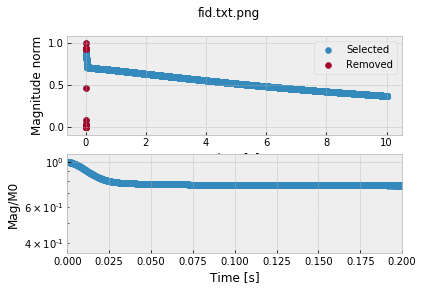

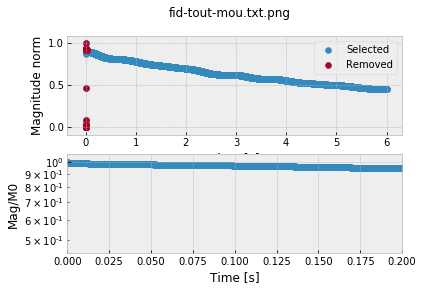

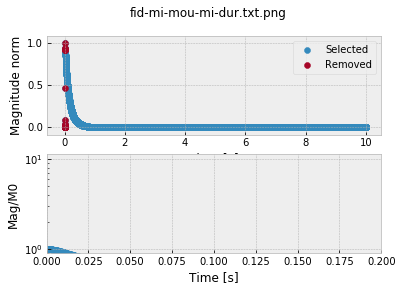

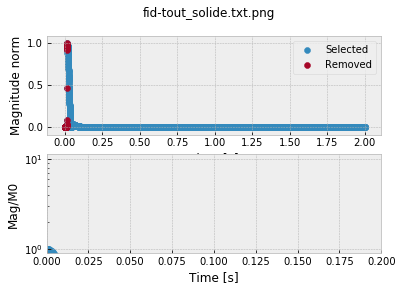

In [9]:
for File in list_files:
    Raw = Load_NormFID(File, d_w, suffix='Mag_', path_in = path_in, path_out = path_out)
    Data = Remove_badpoints(Raw, suffix='Final_', save_plot=True, plot_name =File+'.png', path_out = path_out)